# Pytorch by Examples

### Warm up : Numpy

0 30392761.437672347
50 15474.150004829238
100 536.2353764807206
150 29.970848005444132
200 1.9973594262231484
250 0.1450698435523542
300 0.011037104448403109
350 0.0008647194278803149
400 6.921296939526198e-05
450 5.6398457095459384e-06


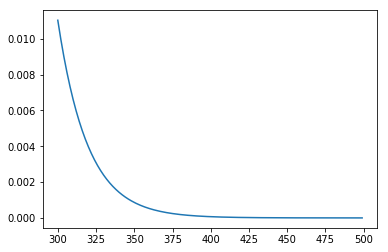

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)

# Randomly initialize weights
w1 = np.random.randn(D_in, H)
w2 = np.random.randn(H, D_out)

epoch = []
losses = []
learning_rate = 1e-6

for t in range(500):
    # Forward pass: compute predicted y
    h = x.dot(w1)
    h_relu = np.maximum(h, 0)
    y_pred = h_relu.dot(w2)

    # Compute and print loss
    loss = np.square(y_pred-y).sum()
    
    epoch.append(t)
    losses.append(loss)
    if t%50 == 0:
        print(t, loss)

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.T.dot(grad_y_pred)
    grad_h_relu = grad_y_pred.dot(w2.T)
    grad_h = grad_h_relu.copy()
    grad_h[h<0] = 0
    grad_w1 = x.T.dot(grad_h)

    # Update weights
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2
    
plt.plot(epoch[300:], losses[300:])
plt.show()

### PyTorch - Tensors

In [38]:
import torch

dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0")

# N is batch size; D_in is input dimension
# H is hidden dimension; D_out is output dimension
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

# Randomly initialize weights
w1 = torch.randn(D_in, H, device=device, dtype=dtype)
w2 = torch.randn(H, D_out, device=device, dtype=dtype)

learning_rate = 1e-6
for t in range(500):
    # Forward pass: compute predicted y
    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)

    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    if t%50 == 0:
        print(t, loss)

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

0 28519142.0
50 10144.17578125
100 236.7060089111328
150 10.500627517700195
200 0.6235345005989075
250 0.04297851026058197
300 0.0034494332503527403
350 0.00046752727939747274
400 0.00012692774180322886
450 5.319342017173767e-05


### PyTorch - Tensors & autogradient

In [39]:
import torch

dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0")

N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold input and outputs.
# Setting requires_grad=False indicates that we do not need to comput gradients
# with respect to these Tensors during the backward pass.
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

# Create random Tensors for weights.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad= True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for t in range(500):
    # Forward pass: compute predicted y using operations on Tensors; these
    # are exactly the same operations we used to compute the forward pass using
    # Tensors, but we do not need to keep references to intermediate values since
    # we are not implementing the backward pass by hand..
    y_pred = x.mm(w1).clamp(min=0).mm(w2)

    # Compute and print loss using operations on Tensors.
    # Now loss is a Tensor of shape (1,)
    # loss.item() gets the a scalar value held in the loss.
    loss = (y_pred - y).pow(2).sum()
    if t % 50 == 0:
        print(t, loss.item())

    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.
    loss.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    # An alternative way is to operate on weight.data and weight.grad.data.
    # Recall that tensor.data gives a tensor that shares the storage with tensor, but doesn't track history.
    # You can also use torch.optim.SGD to achieve this.
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad
        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        w2.grad.zero_()

0 39001156.0
50 16046.673828125
100 864.838623046875
150 78.19257354736328
200 8.473577499389648
250 0.9944329857826233
300 0.12170836329460144
350 0.015389843843877316
400 0.0022659802343696356
450 0.000508145778439939


### PyTorch - defining new autograd function

In [40]:
import torch

class MyReLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        input = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0
        return grad_input

dtype = torch.float
device = torch.device("cpu")

N, D_in, H, D_out = 64, 1000, 100, 10
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1.e-6
for t in range(500):
    relu = MyReLU.apply
    y_pred = relu(x.mm(w1)).mm(w2)

    loss = (y_pred - y).pow(2).sum()
    if t % 50 == 0 :
        print(t, loss.item())

    loss.backward()

    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        w1.grad.zero_()
        w2.grad.zero_()

0 21570962.0


TypeError: '<' not supported between instances of 'tuple' and 'int'